In [1]:
import torch.optim as optim
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#read in the data, get normalized adjacency (NxN)
%run helpers_preproc.ipynb
mesh_dir = 'SHREC11/'

label_np = np.array(readLbl(mesh_dir+'labels.txt'))
label_mat_np = np.where(igl.all_pairs_distances(label_np,label_np,False) > 0.5,0,1)
label_mat = torch.tensor(label_mat_np,requires_grad=False)

In [3]:
normed_adjMats_list = []
node_sigs_list = []

for i in range(600):
    fName = 'T' + str(i) + '.obj'
    adj_noscale_read = obj_2_adj_noscale(mesh_dir + fName)
    adj_scaled_read = obj_2_adj(mesh_dir + fName)

    if (adj_scaled_read.shape[0] < 252):
        adj_noscale = np.empty([252,252])
        adj_scaled = np.empty([252,252])
    else:
        adj_noscale = adj_noscale_read
        adj_scaled = adj_scaled_read

    adj_normalized = adj_noscale / np.reshape(np.sum(adj_noscale,axis = 1),[adj_noscale.shape[0],1])

    node_degs = np.sum(adj_noscale,axis = 0)
    node_neigh_max = np.max(adj_scaled,axis = 0)
    node_neigh_min = np.min(adj_scaled,axis = 0)
    node_neigh_sum = np.sum(adj_scaled,axis = 0)
    node_neigh_mean = np.sum(adj_scaled,axis = 0)

    node_sig = np.stack([node_degs,node_neigh_max,node_neigh_min,node_neigh_sum,node_neigh_mean],axis = 1)
    node_sigs_list.append(node_sig)

    normed_adjMats_list.append(adj_normalized)

#i added this hehehe

/var/folders/t4/vdzymfw562g8ml8ks_2b5l5r0000gn/T/ipykernel_25938/885125645.py:16: RuntimeWarning: invalid value encountered in true_divide
  adj_normalized = adj_noscale / np.reshape(np.sum(adj_noscale,axis = 1),[adj_noscale.shape[0],1])


In [4]:
normed_adjMats = np.stack(normed_adjMats_list)
node_sigs = np.stack(node_sigs_list)

normed_adjMats = torch.tensor(normed_adjMats,requires_grad=False).float()
node_sigs = torch.tensor(node_sigs,requires_grad=False).float()

normed_adjMats = torch.nan_to_num(normed_adjMats,0,0,0)
node_sigs = torch.nan_to_num(node_sigs,0,0,0)

In [5]:
node_sigs

tensor([[[5.0000, 0.0888, 0.0000, 0.3595, 0.3595],
         [7.0000, 0.1017, 0.0000, 0.4655, 0.4655],
         [6.0000, 0.0920, 0.0000, 0.4395, 0.4395],
         ...,
         [7.0000, 0.1142, 0.0000, 0.5429, 0.5429],
         [6.0000, 0.1352, 0.0000, 0.4959, 0.4959],
         [7.0000, 0.1352, 0.0000, 0.5233, 0.5233]],

        [[5.0000, 0.1061, 0.0000, 0.4014, 0.4014],
         [5.0000, 0.1546, 0.0000, 0.4404, 0.4404],
         [5.0000, 0.2171, 0.0000, 0.5315, 0.5315],
         ...,
         [5.0000, 0.1340, 0.0000, 0.4817, 0.4817],
         [6.0000, 0.1705, 0.0000, 0.7666, 0.7666],
         [5.0000, 0.1284, 0.0000, 0.4872, 0.4872]],

        [[4.0000, 0.1228, 0.0000, 0.3313, 0.3313],
         [5.0000, 0.2132, 0.0000, 0.5203, 0.5203],
         [4.0000, 0.1201, 0.0000, 0.2880, 0.2880],
         ...,
         [5.0000, 0.1041, 0.0000, 0.4604, 0.4604],
         [5.0000, 0.1094, 0.0000, 0.4256, 0.4256],
         [4.0000, 0.0913, 0.0000, 0.3470, 0.3470]],

        ...,

        [[5.0000, 0.

In [6]:
class GCN(torch.nn.Module):
    def __init__(self, widths):
        super().__init__()
        self.f = 5
        self.widths = widths
        self.weights = []
        self.weights.append(torch.autograd.Variable(torch.rand(size = [self.f,widths[0]])-0.5,requires_grad = True))

        for i in range(1,len(self.widths)):
            c = self.widths[i]
            self.weights.append(torch.autograd.Variable(torch.rand((self.widths[i-1],self.widths[i]))-0.5,requires_grad = True))

    def forward(self, adjM,node_sigM):
        curr_output = torch.tanh(torch.matmul(torch.matmul(adjM,node_sigM),self.weights[0])) #nxc
        for i in range(1,len(self.widths)):
            curr_output = torch.tanh(torch.matmul(torch.matmul(adjM,curr_output),self.weights[i])) #nxc

        return curr_output

In [7]:
class NNN(torch.nn.Module):
    def __init__(self, widths):
        super().__init__()
        self.input_shape = 2520
        self.widths = widths
        self.weights = []
        self.weights.append(torch.autograd.Variable(torch.rand(size = [self.input_shape,widths[0]])-0.5,requires_grad = True))

        for i in range(1,len(self.widths)):
            c = self.widths[i]
            self.weights.append(torch.autograd.Variable(torch.rand((self.widths[i-1],self.widths[i]))-0.5,requires_grad = True))

    def forward(self, x):
        x = torch.flatten(x,1,2)
        torch.matmul(x,self.weights[0])
        curr_output = torch.tanh(torch.matmul(x,self.weights[0])) #nxc
        for i in range(1,len(self.widths)):
            curr_output = torch.tanh(torch.matmul(curr_output,self.weights[i])) #nxc

        return curr_output

In [8]:
g = GCN([10,10,10,10])
n = NNN([10,10,10,10])
output1 = g.forward(normed_adjMats,node_sigs)
output2 = n.forward(output1)
print(output1)
print(output2)

tensor([[[-0.1551,  0.0792, -0.1879,  ...,  0.2107,  0.1526,  0.1281],
         [-0.1552,  0.0793, -0.1878,  ...,  0.2107,  0.1526,  0.1282],
         [-0.1538,  0.0763, -0.1872,  ...,  0.2108,  0.1510,  0.1283],
         ...,
         [-0.1530,  0.0738, -0.1868,  ...,  0.2110,  0.1502,  0.1273],
         [-0.1535,  0.0749, -0.1867,  ...,  0.2110,  0.1504,  0.1279],
         [-0.1529,  0.0739, -0.1861,  ...,  0.2110,  0.1495,  0.1284]],

        [[-0.1609,  0.0888, -0.1975,  ...,  0.2099,  0.1671,  0.1148],
         [-0.1640,  0.0960, -0.1989,  ...,  0.2098,  0.1708,  0.1146],
         [-0.1616,  0.0909, -0.1976,  ...,  0.2098,  0.1677,  0.1155],
         ...,
         [-0.1603,  0.0885, -0.1972,  ...,  0.2098,  0.1663,  0.1159],
         [-0.1542,  0.0758, -0.1967,  ...,  0.2094,  0.1612,  0.1148],
         [-0.1613,  0.0905, -0.1975,  ...,  0.2098,  0.1673,  0.1158]],

        [[-0.1613,  0.0902, -0.1962,  ...,  0.2101,  0.1661,  0.1169],
         [-0.1612,  0.0897, -0.1960,  ...,  0

In [9]:
def lossF(features):
    disMat = torch.cdist(features,features)
    sameType = disMat * (label_mat-torch.diag(torch.ones(600)))
    diffType = disMat * (1-label_mat)
    sameTypeMean = torch.sum(sameType) / 12000
    diffTypeMean = torch.sum(diffType) /348000

    sameTypeStd = torch.sum((sameType - sameTypeMean)**2) / 12000
    diffTypeStd = torch.sum((diffType - diffTypeMean)**2) / 348000

    #print(disMat)
    return  sameTypeMean - diffTypeMean + 0.2 * (sameTypeStd + diffTypeStd)

In [10]:
optimizer = optim.Adam(g.weights + n.weights,lr = 0.0001)
for i in range(10000):
    optimizer.zero_grad()
    output = n.forward(g.forward(normed_adjMats,node_sigs))
    loss = lossF(output)
    loss.backward()
    optimizer.step()
    print(loss)

tensor(0.0049, grad_fn=<AddBackward0>)
tensor(0.0039, grad_fn=<AddBackward0>)
tensor(0.0028, grad_fn=<AddBackward0>)
tensor(0.0017, grad_fn=<AddBackward0>)
tensor(0.0006, grad_fn=<AddBackward0>)
tensor(-0.0005, grad_fn=<AddBackward0>)
tensor(-0.0016, grad_fn=<AddBackward0>)
tensor(-0.0026, grad_fn=<AddBackward0>)
tensor(-0.0037, grad_fn=<AddBackward0>)
tensor(-0.0047, grad_fn=<AddBackward0>)
tensor(-0.0057, grad_fn=<AddBackward0>)
tensor(-0.0066, grad_fn=<AddBackward0>)
tensor(-0.0074, grad_fn=<AddBackward0>)
tensor(-0.0081, grad_fn=<AddBackward0>)
tensor(-0.0088, grad_fn=<AddBackward0>)
tensor(-0.0094, grad_fn=<AddBackward0>)
tensor(-0.0099, grad_fn=<AddBackward0>)
tensor(-0.0103, grad_fn=<AddBackward0>)
tensor(-0.0107, grad_fn=<AddBackward0>)
tensor(-0.0110, grad_fn=<AddBackward0>)
tensor(-0.0114, grad_fn=<AddBackward0>)
tensor(-0.0117, grad_fn=<AddBackward0>)
tensor(-0.0119, grad_fn=<AddBackward0>)
tensor(-0.0122, grad_fn=<AddBackward0>)
tensor(-0.0124, grad_fn=<AddBackward0>)
tenso

KeyboardInterrupt: 

In [11]:
disMat = torch.cdist(output,output)
sameType = disMat * (label_mat-torch.diag(torch.ones(600)))
diffType = disMat * (1-label_mat)
sameTypeMean = torch.sum(sameType) / 12000
diffTypeMean = torch.sum(diffType) /348000
sameTypeStd = torch.sum((sameType - sameTypeMean)**2) / 12000
diffTypeStd = torch.sum((diffType - diffTypeMean)**2) / 348000

In [12]:
sameTypeMean

tensor(0.1972, grad_fn=<DivBackward0>)

In [13]:
diffTypeMean

tensor(2.0914, grad_fn=<DivBackward0>)

In [18]:
disMat = torch.cdist(output,output).flatten()
mask_same = torch.tensor(label_mat - torch.diag(torch.ones(600)),dtype=bool).flatten()
mask_diff = torch.tensor(1 - label_mat,dtype=bool).flatten()
sameComp = disMat[mask_same].detach().numpy()
diffComp = disMat[mask_diff].detach().numpy()
weightsSame = np.ones_like(sameComp) / len(sameComp)
weightsDiff = np.ones_like(diffComp) / len(diffComp)
bins = torch.arange(0,0.1,0.001)


/var/folders/t4/vdzymfw562g8ml8ks_2b5l5r0000gn/T/ipykernel_25938/4088228649.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask_same = torch.tensor(label_mat - torch.diag(torch.ones(600)),dtype=bool).flatten()
/var/folders/t4/vdzymfw562g8ml8ks_2b5l5r0000gn/T/ipykernel_25938/4088228649.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask_diff = torch.tensor(1 - label_mat,dtype=bool).flatten()


(array([ 4.2535953 , 11.74802512, 20.25521572, 21.06542435, 20.66032003,
        21.47052866, 21.06542435, 21.06542435, 14.38120316, 21.87563298,
        22.6858416 , 19.8501114 , 17.41948552, 16.60927689, 15.79906826,
        13.36844237, 14.78630747, 11.64674904, 12.25440551, 12.55823375,
         9.9250557 , 11.3429208 , 12.35568159, 10.93781649,  7.0893255 ,
         8.91229492,  8.5071906 , 11.3429208 , 10.33016002,  7.29187766,
         6.68422119,  7.69698197,  7.0893255 ,  8.70974276,  5.6714604 ,
         6.68422119,  4.86125177,  4.86125177,  5.26635609,  5.26635609,
         6.68422119,  6.68422119,  4.65869962,  6.88677334,  3.44338667,
         3.44338667,  3.44338667,  5.06380393,  5.06380393,  4.65869962,
         2.43062589,  5.06380393,  3.44338667,  3.64593883,  4.65869962,
         3.84849099,  2.43062589,  2.02552157,  3.03828236,  3.24083451,
         3.64593883,  4.2535953 ,  3.24083451,  2.22807373,  3.03828236,
         4.65869962,  4.45614746,  2.43062589,  2.8

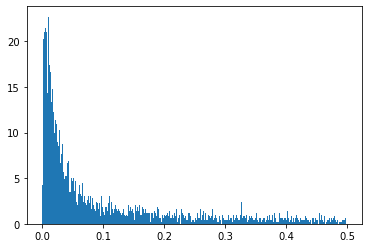

In [20]:
plt.hist(sameComp,bins=np.arange(0,0.5,0.001),density=True)

(array([ 36.,  64.,  60.,  92., 108.,  98., 106., 108., 122., 148., 120.,
        144., 174., 166., 156., 144., 142., 116., 126., 138., 136., 126.,
        136., 112., 106., 120., 114., 132., 118., 158., 158., 132., 142.,
        120., 132., 120., 128., 138., 118., 138., 152., 116., 132., 110.,
        148., 120., 130.,  90., 108., 114., 111., 135.,  88., 122., 122.,
        116., 102., 118., 128., 114., 112., 122., 114., 104., 150., 110.,
        118., 116., 112., 126., 128., 118.,  92., 100., 112.,  98., 112.,
        126., 106.,  98., 108.,  98., 120., 108.,  96., 116.,  98., 126.,
        132.,  96., 128., 100.,  98.,  94., 106., 142., 122., 118., 128.,
        132., 148., 152., 158., 138., 152., 156., 144., 152., 160., 132.,
        140., 148., 172., 144., 170., 188., 136., 156., 194., 146., 138.,
        126., 152., 166., 142., 154., 162., 140., 132., 158., 170., 156.,
        176., 162., 160., 196., 170., 186., 172., 156., 154., 144., 156.,
        184., 162., 126., 120., 138., 

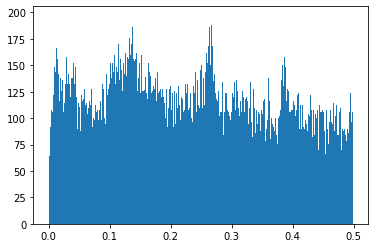

In [22]:
plt.hist(diffComp,bins=np.arange(0,0.5,0.001))